<a href="https://colab.research.google.com/github/specM7/DSGP_Group_33_Brain_Tumor_Predictor/blob/NoTumor-%26-Chatbot-Ahshaan-2506751/ResNet_MRI_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mount Google Drive to access dataset and save trained model
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Import numerical and visualization libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import TensorFlow and Keras modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Import evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report


In [4]:
# Define dataset directory containing MRI and Non-MRI images
dataset_dir = "/content/drive/MyDrive/Validate_MRI_Image/Dataset"


In [5]:
# Define image size and batch size
img_size = 224
batch_size = 16

# Create data generator with normalization and validation split
datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values
    validation_split=0.2     # Split dataset into training and validation sets
)

# Load training dataset
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

# Load validation dataset
val_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 6898 images belonging to 2 classes.
Found 1724 images belonging to 2 classes.


In [6]:
# Load ResNet50 pretrained on ImageNet without top classification layers
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
# Freeze ResNet layers to retain pretrained feature extraction
for layer in base_model.layers:
    layer.trainable = False


In [8]:
# Add custom layers for MRI classification
x = base_model.output
x = GlobalAveragePooling2D()(x)       # Convert feature maps into vector
x = Dense(128, activation='relu')(x)  # Fully connected layer
output = Dense(1, activation='sigmoid')(x)  # Binary output layer

# Create final model
model = Model(inputs=base_model.input, outputs=output)


In [9]:
# Compile model using Adam optimizer and binary cross-entropy loss
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [11]:
# Define number of training epochs
epochs = 15

# Train the model using training and validation datasets
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)


Epoch 1/15
432/432 ━━━━━━━━━━━━━━━━━━━━ 1375s 3s/step - accuracy: 0.9482 - loss: 0.1326 - val_accuracy: 0.9542 - val_loss: 0.1369
Epoch 2/15
432/432 ━━━━━━━━━━━━━━━━━━━━ 1419s 3s/step - accuracy: 0.9640 - loss: 0.1015 - val_accuracy: 0.9594 - val_loss: 0.1062
Epoch 3/15
432/432 ━━━━━━━━━━━━━━━━━━━━ 1360s 3s/step - accuracy: 0.9688 - loss: 0.0882 - val_accuracy: 0.9675 - val_loss: 0.0864
Epoch 4/15
432/432 ━━━━━━━━━━━━━━━━━━━━ 1407s 3s/step - accuracy: 0.9658 - loss: 0.0829 - val_accuracy: 0.9026 - val_loss: 0.1908
Epoch 5/15
432/432 ━━━━━━━━━━━━━━━━━━━━ 1363s 3s/step - accuracy: 0.9658 - loss: 0.0853 - val_accuracy: 0.9791 - val_loss: 0.0600
Epoch 6/15
432/432 ━━━━━━━━━━━━━━━━━━━━ 1417s 3s/step - accuracy: 0.9755 - loss: 0.0638 - val_accuracy: 0.9745 - val_loss: 0.0745
Epoch 7/15
432/432 ━━━━━━━━━━━━━━━━━━━━ 1371s 3s/step - accuracy: 0.9796 - loss: 0.0593 - val_accuracy: 0.9867 - val_loss: 0.0469
Epoch 8/15
432/432 ━━━━━━━━━━━━━━━━━━━━ 1369s 3s/step - accuracy: 0.9819 - loss: 0.0584 - 

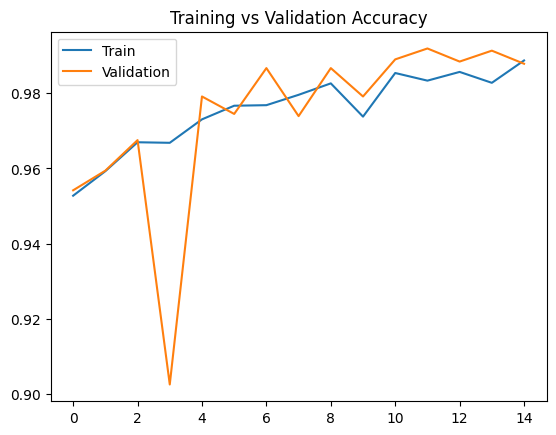

In [12]:
# Plot accuracy graph to monitor training performance
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Training vs Validation Accuracy")
plt.legend(["Train","Validation"])
plt.show()


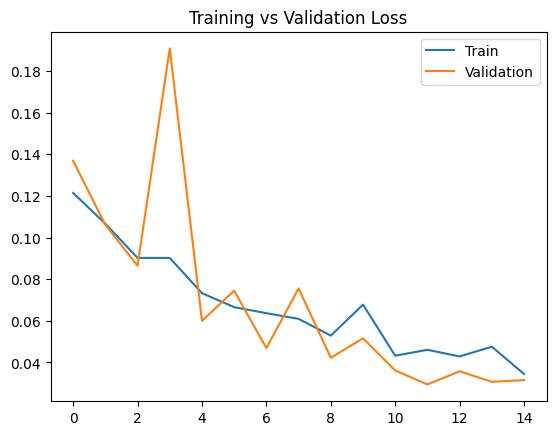

In [13]:
# Plot loss graph to check overfitting or underfitting
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Training vs Validation Loss")
plt.legend(["Train","Validation"])
plt.show()


In [14]:
# Evaluate model accuracy using validation dataset
val_loss, val_acc = model.evaluate(val_generator)
print("Validation Accuracy:", val_acc)


108/108 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.9896 - loss: 0.0287
Validation Accuracy: 0.9878190159797668


108/108 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step


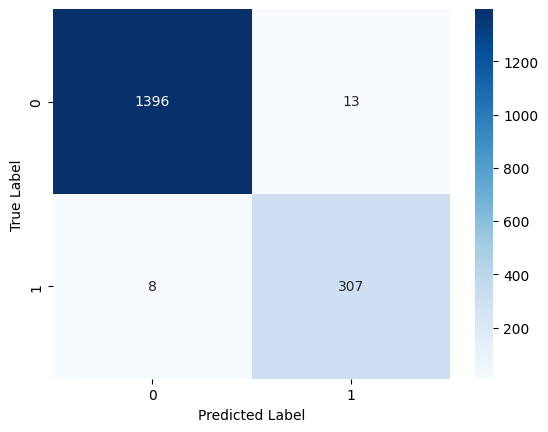

In [15]:
# Predict validation dataset labels
pred_probs = model.predict(val_generator)
pred_labels = (pred_probs > 0.5).astype(int).ravel()

# Get true labels
true_labels = val_generator.classes

# Create confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [16]:
# Display precision, recall, and F1-score
print(classification_report(true_labels, pred_labels))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1409
           1       0.96      0.97      0.97       315

    accuracy                           0.99      1724
   macro avg       0.98      0.98      0.98      1724
weighted avg       0.99      0.99      0.99      1724



In [18]:
# Save trained ResNet MRI validation model
model.save("/content/drive/MyDrive/Validate_MRI_Image/resnet_mri_validator.h5")
print("Model saved successfully")


Model saved successfully


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [19]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab import files


In [21]:
model = load_model("/content/drive/MyDrive/Validate_MRI_Image/resnet_mri_validator.h5")
print("ResNet MRI validation model loaded successfully")


ResNet MRI validation model loaded successfully


In [31]:
# Upload image from local system
uploaded = files.upload()

for fn in uploaded.keys():
    print("\nTesting Image:", fn)

    # Load and preprocess image
    img = image.load_img(fn, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict probability
    prob = float(model.predict(img_array)[0][0])
    print("Probability:", prob)

    # Final decision
    if prob > 0.5:
        print("RESULT: Not MRI Image")
    else:
        print("RESULT: MRI Image Detected")


Saving img.jpg to img (1).jpg

Testing Image: img (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Probability: 3.5021123660421215e-19
RESULT: MRI Image Detected
